# Multivariate Time Series Regression

So far, we have limited our modeling efforts to single time series. RNNs are naturally well suited to multivariate time series and represent a non-linear alternative to the Vector Autoregressive (VAR) models we covered in Chapter 8, Time Series Models. 

## Imports & Settings

In [181]:
import warnings
warnings.filterwarnings('ignore')

In [182]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [184]:
sns.set_style('whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

In [185]:
results_path = Path('results', 'multivariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [186]:
csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL/AAPL_WITH_TWINT_FINBERT_SA.csv"

## Load Data

For comparison, we illustrate the application of RNNs to modeling and forecasting several time series using the same dataset we used for the VAR example, monthly data on consumer sentiment, and industrial production from the Federal Reserve's FRED service in Chapter 8, Time Series Models:

In [187]:
df = pd.read_csv(csv_path, lineterminator='\n', low_memory=False)

df.set_index("date", inplace=True)

df.sort_values(by=["date"], ascending=True, inplace=True)

# df = df[df.index>='2010-01-01']


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               3064 non-null   float64
 1   2. high               3064 non-null   float64
 2   3. low                3064 non-null   float64
 3   4. close              3064 non-null   float64
 4   5. adjusted close     3064 non-null   float64
 5   6. volume             3064 non-null   float64
 6   7. dividend amount    3064 non-null   float64
 7   8. split coefficient  3064 non-null   float64
 8   date_time             3064 non-null   object 
 9   day_of_week           3064 non-null   int64  
 10  return                3064 non-null   float64
 11  increase              3064 non-null   float64
 12  negative              3064 non-null   float64
 13  nuetral               3064 non-null   float64
 14  positive              3064 non-null   float64
 15  log_return 

In [189]:
df.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,date_time,day_of_week,return,increase,negative,nuetral,positive,log_return
date,,,,,,,,,,,,,,,,
2010-01-04,213.43,214.50,212.38,214.01,6.543876,17633200.0,0.0,1.0,2010-01-04,0,0.000000,0.0,0.000013,0.000009,0.999979,0.000000
2010-01-05,214.60,215.59,213.25,214.38,6.555190,21496600.0,0.0,1.0,2010-01-05,1,0.001729,1.0,0.498715,0.001116,0.500169,0.001727
2010-01-06,214.38,215.23,210.75,210.97,6.450921,19720000.0,0.0,1.0,2010-01-06,2,-0.015906,0.0,0.000052,0.085701,0.914247,-0.016034
2010-01-07,211.75,212.00,209.05,210.58,6.438996,17040400.0,0.0,1.0,2010-01-07,3,-0.001849,0.0,0.457010,0.000224,0.542766,-0.001850
2010-01-08,210.30,212.00,209.06,211.98,6.481804,15986100.0,0.0,1.0,2010-01-08,4,0.006648,1.0,0.010157,0.000059,0.989783,0.006626


## Prepare Data

### Stationarity

We apply the same transformation—annual difference for both series, prior log-transform for industrial production—to achieve stationarity that we used in Chapter 8 on Time Series Models:

In [190]:
df.describe()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,day_of_week,return,increase,negative,nuetral,positive,log_return
count,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3.064000e+03,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000
mean,260.329399,262.829696,257.667717,260.335499,42.736360,3.829313e+07,0.013270,1.002937,2.022846,0.001207,0.529047,0.158588,0.090758,0.748042,0.001050
std,159.641209,161.044982,157.946296,159.521075,41.154337,3.233265e+07,0.160922,0.121173,1.399408,0.017675,0.499237,0.143203,0.123167,0.176529,0.017688
min,90.000000,90.700000,89.470000,90.280000,5.872396,5.624800e+06,0.000000,1.000000,0.000000,-0.128647,0.000000,0.000000,0.000000,0.000000,-0.137708
25%,128.377500,129.535000,127.102500,128.525000,16.285903,1.762402e+07,0.000000,1.000000,1.000000,-0.007140,0.000000,0.027276,0.000811,0.651903,-0.007166
50%,192.135000,194.330000,190.875000,192.255000,26.270965,2.763896e+07,0.000000,1.000000,2.000000,0.000942,1.000000,0.140013,0.050226,0.762676,0.000942
75%,364.102500,369.210000,358.682500,364.282500,48.589739,4.667886e+07,0.000000,1.000000,3.000000,0.010459,1.000000,0.242063,0.137521,0.865595,0.010404
max,702.410000,705.070000,699.570000,702.100000,181.778019,3.326072e+08,3.290000,7.000007,4.000000,0.119808,1.000000,1.000000,0.999997,0.999999,0.113157


### Scaling

Then we scale the transformed data to the [0,1] interval:

In [191]:
# df_transformed = df[["2. high", "3. low", "5. adjusted close", "positive"]]

X = df[["5. adjusted close", "2. high", "3. low", "6. volume", "negative", "nuetral", "positive", "log_return"]].values

scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
X_scaled = scaler.transform(X)

### Plot original and transformed series

In [192]:
# fig, axes = plt.subplots(ncols=2, figsize=(14,4))
# columns={'2. high': 'High', '3. low': 'Low', '5. adjusted close': 'adjusted close'}
# df.rename(columns=columns).plot(ax=axes[0], title='Original Series')
# df_transformed.rename(columns=columns).plot(ax=axes[1], title='Tansformed Series')
# sns.despine()
# fig.tight_layout()
# fig.savefig(results_path / 'multi_rnn', dpi=300)

### Reshape data into RNN format

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [193]:
# df.values.reshape(-1, 12, 2).shape

However, we want rolling, not non-overlapping lagged values. The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [194]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] 
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [195]:
window_size = 63

In [213]:
X_scaled[window_size:][0]

array([8.25512128e-03, 2.43403812e-01, 2.41812818e-01, 3.16228065e-02,
       1.45712551e-01, 1.01614855e-04, 8.54186889e-01, 5.66443346e-01])

In [196]:
X, y = create_multivariate_rnn_data(X_scaled, window_size=window_size)

In [197]:
X.shape, y.shape

((3001, 63, 8), (3001, 8))

Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [198]:
# test_size =24
# train_size = X.shape[0]-test_size
train_size = int(len(X) * .9)


In [199]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [200]:
X_train.shape, X_test.shape

((2700, 63, 8), (301, 63, 8))

In [201]:
y_train.shape, y_test.shape

((2700, 8), (301, 8))

## Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 12 and 6 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [202]:
K.clear_session()

In [203]:
n_features = X_train.shape[2]
output_size = 1

In [204]:
lstm_units = 64
dense_units = 4

In [205]:
# rnn = Sequential([
#     LSTM(units=lstm_units,
#          # dropout=.1,
#          # recurrent_dropout=.1,
#          input_shape=(window_size, n_features), name='LSTM',
#          return_sequences=False),
#     tf.keras.layers.Dropout(0.20),
#     Dense(dense_units, name='FC'),
#     Dense(output_size, name='Output')
# ])

# rnn = Sequential([
#     Bidirectional(LSTM(units=lstm_units,
#          # dropout=.1,
#          # recurrent_dropout=.1,
#          input_shape=(window_size, n_features), name='LSTM',
#          return_sequences=True)),
#     tf.keras.layers.Dropout(0.20),
#     # Dense(dense_units, name='FC'),
#     Dense(1, name='Output')
# ])

rnn = Sequential([
    LSTM(units=lstm_units, input_shape=(window_size, n_features), name='LSTM'),
    tf.keras.layers.Dropout(0.20),
# #    LSTM(units=63, 
# #           input_shape=(window_size, n_features), name='LSTM2'),
   Dense(1, name='Output')
])

The model has 1,268 parameters, as shown here:

## Train the Model

We train for 50 epochs with a batch_size value of 20 using early stopping:

In [206]:
lstm_path = (results_path / 'lstm.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [207]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001,
                                     # learning_rate=lr_schedule,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

In [208]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=30,
                              restore_best_weights=True)

In [209]:
# rnn.compile(loss='mean_absolute_error', optimizer=optimizer)

rnn.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=optimizer,
            metrics=[tf.metrics.MeanAbsoluteError()])

In [210]:
# rnn.summary()

In [211]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=32,
                 shuffle=True,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
85/85 [==============================] - ETA: 0s - loss: 0.0799 - mean_absolute_error: 0.2370
Epoch 1: val_loss improved from inf to 0.09299, saving model to results/multivariate_time_series/lstm.h5
85/85 [==============================] - 4s 24ms/step - loss: 0.0799 - mean_absolute_error: 0.2370 - val_loss: 0.0930 - val_mean_absolute_error: 0.2704
Epoch 2/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0772 - mean_absolute_error: 0.2357
Epoch 2: val_loss improved from 0.09299 to 0.09241, saving model to results/multivariate_time_series/lstm.h5
85/85 [==============================] - 2s 18ms/step - loss: 0.0769 - mean_absolute_error: 0.2351 - val_loss: 0.0924 - val_mean_absolute_error: 0.2735
Epoch 3/100
82/85 [===========================>..] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.2348
Epoch 3: val_loss did not improve from 0.09241
85/85 [==============================] - 1s 16ms/step - loss: 0.0764 - mean_absolute_error: 0.2347 - val_loss: 0.0925

KeyboardInterrupt: 

## Evaluate the Results

Training stops early after 22 epochs, yielding a test MAE of 1.71, which compares favorably to the test MAE for the VAR model of 1.91.

However, the two results are not fully comparable because the RNN model produces 24 one-step-ahead forecasts, whereas the VAR model uses its own predictions as input for its out-of-sample forecast. You may want to tweak the VAR setup to obtain comparable forecasts and compare their performance:

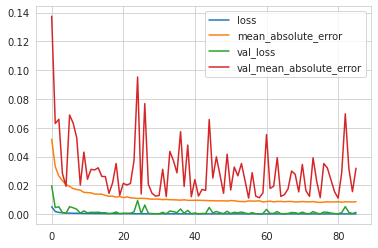

In [ ]:
pd.DataFrame(result.history).plot();

In [ ]:
train_predict_scaled = rnn.predict(X_train).squeeze()

test_predict_scaled = rnn.predict(X_test).squeeze()

In [ ]:
print(len(train_predict_scaled))
print(len(test_predict_scaled))

2700
301


In [ ]:
train_mae = mean_absolute_error(df_transformed[:train_size]['5. adjusted close'], train_predict_scaled)
test_mae = mean_absolute_error(df_transformed[train_size+window_size:]['5. adjusted close'], test_predict_scaled)
f'Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}'

'Train MAE: 0.0245 | Test MAE: 0.0111'

In [101]:
_ = np.array(train_predict_scaled)
_ = np.c_[_, np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0]), np.zeros(_.shape[0])]

In [102]:
_train_predict_scaled = scaler.inverse_transform(_)

NameError: name 'scaler' is not defined